In [1]:
## 使用了HCP_Sch中的预训练模型

In [1]:
import os, glob
import numpy as np
import pandas as pd

In [2]:
root_path = []
root_path.append('/home/neurolab/NeuroRaid/PlusRaid/Data2017/Data_Schiz/AllLabeled_Sternberg_three_errts/')

In [3]:
all_file = []
for path in root_path:
    all_file.extend(glob.glob(path + '*.nii.gz'))

In [4]:
info = []
for i in xrange(len(all_file)):
    info.append([all_file[i].split(os.sep)[-1].split('_')[0], all_file[i].split(os.sep)[-1].split('_')[2]] + [all_file[i].split(os.sep)[-1]] + [all_file[i]])

df = pd.DataFrame(info, columns=['userID', 'task', 'file_name', 'file_path'])
df = df.sort_values(['userID'])
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

In [5]:
df = pd.get_dummies(df, columns=['task'])

In [8]:
# old_data = glob.glob('../HCP_Sch/AllLabeledLong5/*')
# import nibabel as nib
# data = nib.load(all_file[135]).get_data()

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, _, _ = train_test_split(df.userID.unique(), df.userID.unique(), test_size=0.3, random_state=42)
X_test, X_val, _, _ = train_test_split(X_test, X_test, test_size=0.33, random_state=42)

fun = lambda df, id_list: [df[df.userID.isin(id_list)]['file_path'].values, df[df.userID.isin(id_list)].iloc[:, 3:].values]

X_train, y_train = fun(df, X_train) 
X_test, y_test = fun(df, X_test) 
X_val, y_val = fun(df, X_val) 

/home/neurolab/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# val_file_name = [X_val[i].split(os.sep)[-1] for i in range(len(X_val))]

# tmp_df = pd.DataFrame(val_file_name, columns=['file_name'])

# tmp_df.to_csv('val_file.csv', index=False)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset

In [10]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x, is_volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    if is_volatile:
        return Variable(x, volatile=True)
    else:
        return Variable(x)

In [11]:
import nibabel as nib
motor_mask = nib.load('/home/neurolab/NeuroRaid/PlusRaid/Data2017/Data_Schiz/mask_motor.nii.gz').get_data()
class BrainDataset(Dataset):
    def __init__(self, root_path, file_list, label_list, train=True):
        self.train = train
        self.input_shape = 21
        self.root_path = root_path
        self.file_list = file_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        img = self.normalize_data(nib.load(os.path.join(self.root_path, self.file_list[index])).get_data())
#         img = self.normalize_data(nib.load(os.path.join(self.root_path, self.file_list[index][:-3])).get_data())
        target = np.argmax(self.label_list[index])
        return img, target
    
    def __len__(self):
        return len(self.label_list)
    
    def normalize_data(self, data):
        
        data = data * (1 - motor_mask)[..., np.newaxis]
        if self.train:
#             print str(self.input_shape) + '   ' +  str(data.shape[-1])
            select_idx = np.random.randint(low=self.input_shape, high=data.shape[-1], size=1)[0]
            data = data[4:-5, 5:-4, :-6, select_idx-self.input_shape:select_idx]
        else:
            data = data[4:-5, 5:-4, :-6, :self.input_shape]
        data = data / 10000. #data.max(axis=3)[:, :, :, np.newaxis]
        data[~ np.isfinite(data)] = 0
        
        return data.transpose(3, 0, 1, 2)

/home/neurolab/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PostRes(nn.Module):
    def __init__(self, n_in, n_out, stride = 1):
        super(PostRes, self).__init__()
        self.conv1 = nn.Conv3d(n_in, n_out, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm3d(n_out)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv3d(n_out, n_out, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm3d(n_out)

        self.relu2 = nn.ReLU(inplace = True) #for vis
        if stride != 1 or n_out != n_in:
            self.shortcut = nn.Sequential(
                nn.Conv3d(n_in, n_out, kernel_size = 1, stride = stride),
                nn.BatchNorm3d(n_out))
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        if self.shortcut is not None:
            residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu2(out)
        return out
    
class DeepBrain(nn.Module):
    def __init__(self, block=PostRes):
        super(DeepBrain, self).__init__()
        self.n_classes = 2
        self.in_planes = 16
        
        self.preBlock = nn.Sequential(
            nn.Conv3d(21, 3, kernel_size=1, padding=0),
            nn.BatchNorm3d(3),
            nn.ReLU(inplace=True),
            nn.Conv3d(3, 24, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(24),
            nn.ReLU(inplace = True))
        
        self.layer_1 = self._make_layer(block,  24, 32, 2)
        self.layer_2 = self._make_layer(block, 32, 64, 2, pooling=True)
        self.layer_3 = self._make_layer(block, 64, 64, 2, pooling=True)
        self.layer_4 = self._make_layer(block, 64, 128, 2, pooling=True)
        
        self.pool = nn.AdaptiveMaxPool3d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 1, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, self.n_classes),
            nn.LogSoftmax())
        
        self._initialize_weights()
        
    def _make_layer(self, block, planes_in, planes_out, num_blocks, pooling=False, drop_out=False):
        layers = []
        if pooling:
            layers.append(nn.MaxPool3d(kernel_size=2, stride=2))
        layers.append(block(planes_in, planes_out))
        for i in range(num_blocks - 1):
            layers.append(block(planes_out, planes_out))
            
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.xavier_uniform(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
    def forward(self, x):
        
        x = self.preBlock(x)

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        
        x = self.pool(x)
        x = x.view(-1, 128 * 1)
        
        x = self.classifier(x)
        
        return x

In [13]:
# ##模型迁移
# def assign(net1, net2):
#     for param1, param2 in zip(net1.parameters(), net2.parameters()):
#         param1.data = param2.data

# from model import *
# old_net = torch.load('../HCP_Sch/Model_Multiclass_WD/DeepBrain_epoch_97.pkl')

# new_net = DeepBrain()

# assign(new_net.preBlock, old_net.preBlock)
# assign(new_net.layer_1, old_net.layer_1)
# assign(new_net.layer_2, old_net.layer_2)
# assign(new_net.layer_3, old_net.layer_3)
# assign(new_net.layer_4, old_net.layer_4)

# torch.save(new_net, 'Model/finetuning_97_9.pkl')

In [14]:
net = DeepBrain()
# net = torch.load('Model/finetuning_97_9.pkl')
if torch.cuda.is_available():
    net.cuda()
criterion = nn.NLLLoss().cuda()
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
# optimizer =  torch.optim.SGD(net.parameters(), lr = learning_rate, momentum=0.9)

In [15]:
num_epochs = 250
batch_size = 24
num_workers = 6

trainset = BrainDataset(root_path=root_path, file_list=X_train, label_list=y_train, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

valset = BrainDataset(root_path=root_path, file_list=X_val, label_list=y_val, train=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

testset = BrainDataset(root_path=root_path, file_list=X_test, label_list=y_test, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
from logger import Logger
logger = Logger('./logs')

In [ ]:
step = 0
for epoch in range(num_epochs):
    print 'epoch:' + str(epoch)
    total_loss = 0.0
    total_accuracy = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = to_var(inputs), to_var(labels)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data[0]
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax.squeeze()).float().mean()
        total_accuracy += accuracy.data[0]
        
        step += 1
        if (i+1) % 30 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d], Loss: %.6f, Acc: %.6f' 
                       %(epoch+1, num_epochs, i+1, len(X_train) / batch_size, total_loss / (i+1), total_accuracy / (i+1)))
            
            info = {
                'train_loss': total_loss / (i+1),
                'train_accuracy': total_accuracy / (i+1)
            }

            for tag, value in info.items():
                logger.scalar_summary(tag, value, step+1)

            # (2) Log values and gradients of the parameters (histogram)
            for tag, value in net.named_parameters():
                tag = tag.replace('.', '/')
                logger.histo_summary(tag, to_np(value), step+1)
                logger.histo_summary(tag+'/grad', to_np(value.grad), step+1)
    torch.save(net, 'Model/Model_finetuning_97epoch_9long/DeepBrain_epoch_{}.pkl'.format(epoch))            
                
    total_loss = 0.0
    total_accuracy = 0.0
    net.eval()
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = to_var(inputs, is_volatile=True), to_var(labels, is_volatile=True)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        total_loss += loss.data[0]
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax.squeeze()).float().mean()
        total_accuracy += accuracy.data[0]
        
    info = {
        'val_loss': total_loss / (i+1),
        'val_accuracy': total_accuracy / (i+1)
    }

    for tag, value in info.items():
        logger.scalar_summary(tag, value, step+1)

epoch:0


/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/250], Iter [30/62], Loss: 0.691282, Acc: 0.495833
Epoch [1/250], Iter [60/62], Loss: 0.691722, Acc: 0.525000


/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type DeepBrain. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type PostRes. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch:1
Epoch [2/250], Iter [30/62], Loss: 0.681467, Acc: 0.559722
Epoch [2/250], Iter [60/62], Loss: 0.684972, Acc: 0.563194
epoch:2
Epoch [3/250], Iter [30/62], Loss: 0.676233, Acc: 0.591667
Epoch [3/250], Iter [60/62], Loss: 0.670215, Acc: 0.602083
epoch:3
Epoch [4/250], Iter [30/62], Loss: 0.648522, Acc: 0.626389
Epoch [4/250], Iter [60/62], Loss: 0.645256, Acc: 0.635417
epoch:4
Epoch [5/250], Iter [30/62], Loss: 0.626156, Acc: 0.659722
Epoch [5/250], Iter [60/62], Loss: 0.616762, Acc: 0.668056
epoch:5
Epoch [6/250], Iter [30/62], Loss: 0.618362, Acc: 0.675000
Epoch [6/250], Iter [60/62], Loss: 0.586567, Acc: 0.701389
epoch:6
Epoch [7/250], Iter [30/62], Loss: 0.530413, Acc: 0.741667
Epoch [7/250], Iter [60/62], Loss: 0.537507, Acc: 0.745139
epoch:7
Epoch [8/250], Iter [30/62], Loss: 0.505761, Acc: 0.759722
Epoch [8/250], Iter [60/62], Loss: 0.497702, Acc: 0.759722
epoch:8
Epoch [9/250], Iter [30/62], Loss: 0.432919, Acc: 0.800000
Epoch [9/250], Iter [60/62], Loss: 0.454579, Acc: 0

Process Process-213:
Traceback (most recent call last):
Process Process-215:
  File "/home/neurolab/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/neurolab/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/neurolab/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
  File "/home/neurolab/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    samples = collate_fn([dataset[i] for i in batch_indices])
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-11-b004e61aadd3>", line 12, in __getitem__
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    img = self

Traceback (most recent call last):
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/neurolab/anaconda2/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/neurolab/anaconda2/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/neurolab/anaconda2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader

IndexError: string index out of range

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 636, in _abort_queues
    self._abort_queue(stream)
  File "/home/neurolab/

In [ ]:
###模型迁移
# def assign(net1, net2):
#     for param1, param2 in zip(net1.parameters(), net2.parameters()):
#         param1.data = param2.data

# from model import *
# old_net = torch.load('../HCP_Sch/Model_Multiclass_WD/DeepBrain_epoch_97.pkl')

# new_net = DeepBrain()

# assign(new_net.layer_1, old_net.layer_1)
# assign(new_net.layer_2, old_net.layer_2)
# assign(new_net.layer_3, old_net.layer_3)
# assign(new_net.layer_4, old_net.layer_4)

# 测试

In [ ]:
net = torch.load('Model_new/DeepBrain_epoch_46.pkl')
if torch.cuda.is_available():
    net.cuda()

In [ ]:
# val
total_loss = 0.0
total_accuracy = 0.0
net.eval()
for i, data in enumerate(valloader, 0):
    inputs, labels = data
    inputs, labels = to_var(inputs, is_volatile=True), to_var(labels, is_volatile=True)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    total_loss += loss.data[0]

    # Compute accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    total_accuracy += accuracy.data[0]

In [18]:
total_accuracy / (i+1)

0.9317396313364056

In [16]:
# test
total_loss = 0.0
total_accuracy = 0.0
net.eval()
predict_prob = []
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = to_var(inputs, is_volatile=True), to_var(labels, is_volatile=True)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    total_loss += loss.data[0]

    # Compute accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    total_accuracy += accuracy.data[0]
    predict_prob.append(F.softmax(outputs).data.cpu().numpy())

/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  

In [17]:
predict_label = np.concatenate(predict_prob, 0)
prob_predict = np.argmax(predict_label, axis=1)

np.save('2018_5_28_test_predict.npy', predict_label)

In [18]:
print 'Epoch_{}:    val_loss:{}      val_accuracy:{}'.format(0, total_loss / (i+1), total_accuracy / (i+1))

Epoch_0:    val_loss:0.257498207295      val_accuracy:0.94651813267


In [19]:
gt = np.argmax(y_test, axis=1)

In [22]:
task_info = []
for i in xrange(len(X_test)):
    task_info.append('_'.join(X_test[i].split(os.sep)[-1].split('_')[1:3]))

In [47]:
task_name = list(np.sort(list(set(task_info))))

In [48]:
stat_predict = np.zeros((33, 7))

In [49]:
for i, name in enumerate(X_test):
    stat_predict[task_name.index('_'.join(name.split(os.sep)[-1].split('_')[1:3])), prob_predict[i]] += 1

In [50]:
final_df = pd.DataFrame(columns=['Label', 'Predict Label', 'Count'])

In [51]:
count = 0
for i in range(33):
    for j in range(7):
        final_df.loc[count] = [task_name[i], df.columns[3:][j], stat_predict[i, j]]
        count += 1

In [52]:
final_df['Count'] = final_df['Count'].astype(int)

In [53]:
final_df = final_df.pivot('Label', 'Predict Label', 'Count')

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

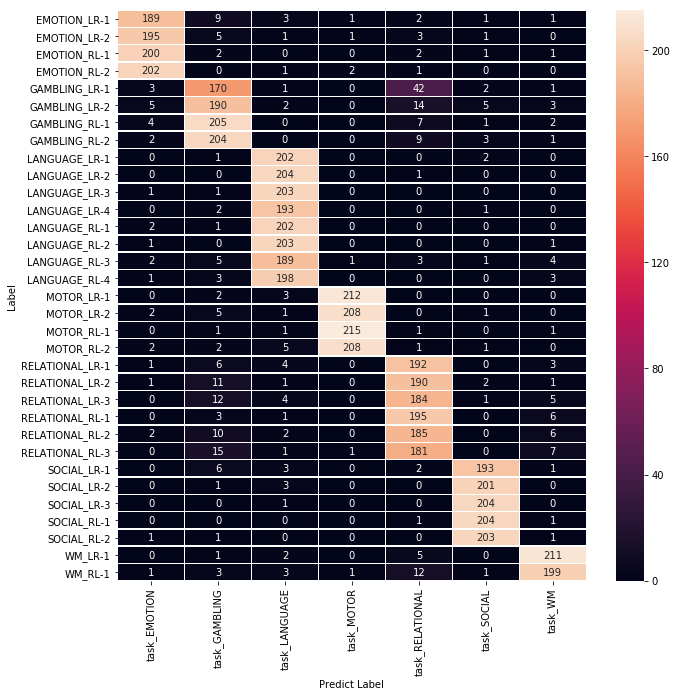

In [55]:
plt.figure(figsize=(10.5, 10.5))
sns.heatmap(final_df, annot=True, fmt="d", linecolor='white', linewidths=0.5)

fig = plt.gcf()

In [59]:
fig.savefig('OutputResult/2018_5_28_confusion_matrix.pdf', dpi = 300)

# 可视化测试

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
from torch.nn import Parameter
from torchvis import util
def normalize_data(data, train=False):
    if train:
        select_idx = np.random.randint(low=27, high=data.shape[-1], size=1)[0]
        data = data[8:-8, 8:-8, :-10, select_idx-self.input_shape:select_idx]
    else:
        data = data[8:-8, 8:-8, :-10, :27]
    data = data / data.max(axis=3)[:, :, :, np.newaxis]
    data[~ np.isfinite(data)] = 0
    return data.transpose(3, 0, 1, 2)

In [15]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.preBlock._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that it only returns positive gradients
        """
        def relu_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, changes it to zero
            """
            if isinstance(module, nn.ReLU):
                return (torch.clamp(grad_in[0], min=0.0),)
        # Loop through layers, hook up ReLUs with relu_hook_function
        
        block_name = ['preBlock', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'post_conv']
        for name in block_name:
            for pos, module in getattr(self.model, name)._modules.items():
                if isinstance(module, nn.ReLU):
                    module.register_backward_hook(relu_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

In [16]:
import tqdm

In [ ]:
####  迭代 ####
net = torch.load('Model_new/DeepBrain_epoch_46.pkl').cuda()
_ = net.eval()
GBP = GuidedBackprop(net)
for i in tqdm.tqdm(range(len(X_test))):

    file_name = X_test[i]
    
    inputs = torch.FloatTensor(normalize_data(nib.load(file_name).get_data())[np.newaxis, ...])
    
    input_img = Parameter(inputs.cuda(), requires_grad=True)
    
    if input_img.grad is not None:
        input_img.grad.data.zero_()
        
    GBP.model.zero_grad()
    
    output_grad = GBP.generate_gradients(input_img, np.where(y_test[i] == 1)[0][0])

    export_gradient = np.zeros((27, 91, 109, 91))
    export_gradient[:, 8:-8, 8:-8, :-10] = output_grad[0, :]

    nifti_img = nib.Nifti1Image(export_gradient.transpose(1, 2, 3, 0), np.eye(4))
    nifti_img.to_filename('OutputResult/Visualize_Model/gradient_{}.nii.gz'.format(file_name.split(os.sep)[-1].split('.')[0]))

  0%|          | 0/6902 [00:00<?, ?it/s]/home/neurolab/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/home/neurolab/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  1%|          | 45/6902 [02:16<5:46:17,  3.03s/it]

# 存储预测结果

In [7]:
predict_label = np.load('2018_5_28_test_predict.npy')

In [9]:
prob_predict = np.argmax(predict_label, axis=1)

In [31]:
col_name = ['file_name']
col_name.extend(df.columns[3:])

In [34]:
predict_df = pd.DataFrame(columns=col_name)

In [35]:
predict_df['file_name'] = X_test

In [38]:
predict_df.replace(np.nan, 0, inplace=True)

In [40]:
prob_predict

array([5, 0, 4, ..., 3, 1, 4])

In [41]:
for i, idx in enumerate(prob_predict):
    predict_df.iloc[i, idx+1] = 1

In [44]:
predict_df.iloc[1, :]['file_name']

'/media/neurolab/Cache/AllRepeatsCutAndLabel/100408_EMOTION_LR-1_fear.nii.gz'

In [45]:
predict_df.to_csv('OutputResult/predict_label.csv', index=False)

# ROC

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
%matplotlib inline

In [11]:
predict_label = np.load('2018_5_28_test_predict.npy')

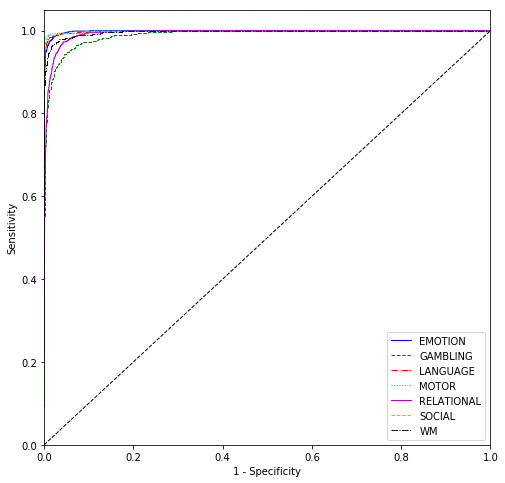

In [17]:
n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predict_label[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')

lw = 1

col_name = [name.split('_')[1] for name in df.columns.values[3:]]

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
fig = plt.figure(figsize=(8,8))
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
linestyles = cycle(['solid', 'dashed', 'dashdot', 'dotted'])
for i, color, linesty in zip(range(n_classes), colors, linestyles):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=col_name[i], ls=linesty)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('')
plt.legend(loc="lower right")
fig = plt.gcf()
plt.show()

In [19]:
fig.savefig('OutputResult/2018_5_28_ALL_test_ROC.pdf', dpi = 300)

In [18]:
roc_auc

{0: 0.9986820803662421,
 1: 0.9897800171858023,
 2: 0.9988099338362296,
 3: 0.999425559511312,
 4: 0.9937754269495729,
 5: 0.9990373946010898,
 6: 0.9968416678503216}